# News Events

**Purpose:** Compare outlet leadership within multi-article news events.

**Steps:**
1. Load/filter dataframe of multi-article clusters
2. Make dyads per cluster
3. Filter dyads per cluster
    - Export filtered version to pickle
4. Shift from cluster-level to dyad-level
5. Comparisons

**Note:** Each outlet is associated one-to-one with a `doctype`. Each `doctype` is categorized under a `doctype_ideo` value, which is either "alternative-right" or "established-right".

In [31]:
import os
import pickle
import itertools
from pprint import pprint

In [2]:
%matplotlib inline

In [3]:
# matplotlib is logged even though disable_existing_loggers=yes in logging_config.yaml
# https://stackoverflow.com/a/51529172/7016397
# workaround is to manually set the level before creating my logger
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

from usrightmedia.shared.loggers import get_logger

In [4]:
df_dir = os.path.join("..", "..", "data", "02-intermediate", "07-newsevents", "05-softcosine-clusters", "dataframes")
dyads_dir = os.path.join("..", "..", "data", "02-intermediate", "07-newsevents", "06-softcosine-dyads")

In [5]:
from usrightmedia.shared.clusters_utils import *

INFO:INCA:Providing verbose output


In [6]:
# for exporting df_urls
urls_dir = os.path.join("..", "..", "data", "03-analysis")
figs_dir = os.path.join("..", "..", "figures", "dyadic")
def save_image(obj, name, height=5, width=7, units="in", dpi=300):
    obj.save(filename = os.path.join(figs_dir, "svg", f'{name}.svg'), height=height, width=width, units=units, dpi=None)
    obj.save(filename = os.path.join(figs_dir, "png", f'{name}.png'), height=height, width=width, units=units, dpi=dpi)

<hr>

## Full version

### 1. Load dataframe of multi-article clusters
- Select the softcosine threshold whose clusters represent news events
- Add columns for:
    - `doctype`: corresponds with the outlet names
    - `doctype_ideo`: "est" ("established right") or "alt" ("alternative right")
    - `doc_topic`: the primary topic assigned to the document per topic modeling
    - `doc_tw`: list of `tweets2_url` IDs (the doc's URL was tweeted or re-tweeted 1+ times by congressional Republicans who served during 2016 - 2020)
- `rmv_docs_with_odd_publish_date_ind=True`: remove documents published at exactly 05:00 UTC (midnight EST)
- Filter for selected year(s) and topic(s). If the corresponding value(s) is an empty list, no filtering is used and all documents are kept in the dataset.

In [7]:
threshold = "softcos06"
# LOGGER = get_logger(filename = f'06-dyadic-comparison-{threshold}', logger_type='main')

In [7]:
# %%time
# df_clusters = load_multi_doc_clusters_only(df_dir, threshold)
# df_clusters["doctype"] = df_clusters["doc_id"].map(lambda d: extract_doctype(d))
# df_clusters["doctype_ideo"] = df_clusters["doctype"].map(lambda d: get_ideo_subcategory(d))

In [8]:
# check that number of unique clusters matches the charts from 03-softcosine-clusters.ipynb
# df_clusters["cluster_id"].nunique()

In [9]:
# number of documents which are members of multi-doc clusters
# len(df_clusters)

# TODO: topic model assignment

In [10]:
%%time
# more efficient to query all doc_ids together than to send an HTTP request to ES for each doc_id.
# store the retrieved data in a helper dataframe (df_topics, df_tw) which is then used to populate df_clusters.

# TODO
# df_topic = get_field_value_for_ids(list(df_clusters["doc_id"]), "topic")
# df_clusters["doc_topic"] = df_clusters["doc_id"].map(lambda d: df_topic.at[d, "topic"])
# df_clusters["doc_topic"] = df_clusters["doc_id"].map(lambda d: get_doc_topic(d)) # placeholder values - remove this line afterwards

# df_tw = get_field_value_for_ids(list(df_clusters["doc_id"]), "tweets2_url_ids")
# df_clusters["doc_tw"] = df_clusters["doc_id"].map(lambda d: df_tw.at[d, "tweets2_url_ids"])

# df_clusters_filtered = filter_clusters(
#                             df_clusters,
#                             rmv_docs_with_odd_publish_date_ind=True,
#                             filters={"years": [],
#                                      "topics": []}
#                         )

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 4.77 µs


In [11]:
# number of documents which are members of multi-doc clusters which don't have odd dates
# len(df_clusters_filtered)

In [12]:
# df_clusters_filtered.to_pickle(os.path.join(dyads_dir,  f"{threshold}_df_clusters_filtered.pkl"))

### 2. Make dyads per cluster
- A cluster can consist of 0 or more dyads.
    - The dyad list is empty if only 1 document remained after the filters above.
    - The dyad list contains 1+ dyads if there were at least 2+ documents remaining in the cluster.
    
- For each dyad:
    - The first position is occupied by the doctype (i.e., outlet) which publishes the oldest article within the cluster.
    - The second position is occupied by a doctype which publishes a subsequent article within the cluster.
    
- `dyads`: two-item tuple where each item is a dict. Each dict represents a document.
- `dyads_cx`: dictionary where the key is the `cluster_id` and the value is the list of dyads associated with it.
- `dyads_cid`: the dyads for one cluster

In [13]:
%%time
# dyads_cx = get_clusters_as_dyads(df_clusters_filtered)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


In [14]:
# with open(os.path.join(dyads_dir, f'{threshold}_dyads_cx.pkl'), 'wb') as file:
#       pickle.dump(dyads_cx, file)

### 3. Filter dyads per cluster

`keep_dyads_bn_diff_doctypes_only=True`: 
- If the second outlet is the same as the first outlet, then the dyad is excluded.
- Example, 4-article news event:
    - Breitbart publishes the 1st article (D1)
    - Fox News publishes the 2nd article (D2)
    - Breitbart publishes the 3rd outlet (D3)
    - Daily Stormer publishes the 4th outlet (D4)
- Result:
    - D1-D2: included
    - D1-D3: excluded (same outlet in the first and second positions of the dyad)
    - D1-D4: included
    
`keep_first_doctype_pair_only=True`:
- Only the first instance of a doctype pair is kept.
- Example, 3-article news event:
    - Newsmax publishes the 1st article (D1)
    - One America News publishes the 2nd article (D2)
    - One America News publishes the 3rd article (D3)
- Result:
    - D1-D2: included
    - D1-D3: excluded (repeat of "newsmax-oneamericanews" pair)

- Filter dyads for dyadic comparison: `keep_first_doctype_pair_only=True` so that at most one instance is counted between outlets per news event.

In [15]:
%%time
dyads_cx_filtered = filter_dyads(dyads_cx,
                                 keep_dyads_bn_diff_doctypes_only=True,
                                 keep_first_doctype_pair_only=True)

with open(os.path.join(dyads_dir, f'{threshold}_dyads_cx_filtered.pkl'), 'wb') as file:
      pickle.dump(dyads_cx_filtered, file)

- Filter dyads for indirect political resonance (IPR): `keep_first_doctype_pair_only=False`

In [16]:
# dyads_cx_filtered_IPR = filter_dyads(dyads_cx,
#                                  keep_dyads_bn_diff_doctypes_only=True,
#                                  keep_first_doctype_pair_only=False)

# with open(os.path.join(dyads_dir, f'{threshold}_dyads_cx_filtered_IPR.pkl'), 'wb') as file:
#       pickle.dump(dyads_cx_filtered_IPR, file)

In [8]:
# load from file if already calculated 
dyads_cx_filtered = pickle.load(open(os.path.join(dyads_dir, f'{threshold}_dyads_cx_filtered.pkl'),'rb'))

### 4. Shift from cluster-level to dyad-level

In [9]:
# %%time
dyads_filtered = extract_dyads(dyads_cx_filtered)

### 5. Comparisons
- In the comparison tables, the doctype (i.e., outlet) in the row is the leader and the doctype in the column is the follower.

#### 5.1 Dyadic comparisons

![dyadic comparison](https://raw.githubusercontent.com/wlmwng/us-right-media/develop/usrightmedia/figures/dyadic_comparison.svg?token=AFRZSYUKYSPHLQKR4U45Z33BUSEIG)

In [10]:
# spot-check the cells in dyadic_count_doctype
matched = get_matched_dyads(dyads=dyads_filtered,
                      d0_key="doctype",
                      d1_key="doctype",
                      d0_values=["dailycaller"],
                      d1_values=["newsmax"])

len(matched)

1265

To calculate the total number of dyads that an outlet participates in: <br>
`dyadic_count_doctype.at[DOCTYPE, "All"] + dyadic_count_doctype.at["All", DOCTYPE]`

In [11]:
dyadic_count_doctype = make_dyadic_comparison(dyads=dyads_filtered, key="doctype", version="count")
dyadic_count_doctype

,All,americanrenaissance,breitbart,dailycaller,dailystormer,foxnews,gatewaypundit,infowars,newsmax,oneamericanews,rushlimbaugh,seanhannity,vdare,washingtonexaminer
All,71220,1830,14509,12518,1350,12248,4389,4406,9840,3733,340,993,616,4448
americanrenaissance,344,0,87,54,30,52,14,12,20,11,2,2,50,10
breitbart,10334,487,0,2237,310,2394,927,1203,1175,515,60,177,162,687
dailycaller,12001,265,3287,0,149,3085,1013,914,1265,403,88,191,102,1239
dailystormer,382,36,99,57,0,58,22,30,43,20,1,3,5,8
foxnews,19377,395,4752,4933,331,0,1120,886,3737,1440,77,333,119,1254
gatewaypundit,3450,90,862,657,73,594,0,430,275,71,35,78,27,258
infowars,1417,55,402,216,68,245,169,0,114,46,7,18,23,54
newsmax,7539,102,1601,1337,137,2103,358,280,0,913,14,68,52,574
oneamericanews,7471,87,1450,966,132,2026,107,299,1998,0,8,23,34,341


In [12]:
dyadic_prop_doctype = make_dyadic_comparison(dyads=dyads_filtered, key="doctype", version="proportion")
# displays as percentages
dyadic_prop_doctype.round(decimals=3).select_dtypes(include=["number"])*100

,All,americanrenaissance,breitbart,dailycaller,dailystormer,foxnews,gatewaypundit,infowars,newsmax,oneamericanews,rushlimbaugh,seanhannity,vdare,washingtonexaminer
All,50.0,84.2,58.4,51.1,77.9,38.7,56.0,75.7,56.6,33.3,70.8,80.8,50.8,35.9
americanrenaissance,15.8,0.0,15.2,16.9,45.5,11.6,13.5,17.9,16.4,11.2,40.0,33.3,19.1,9.6
breitbart,41.6,84.8,0.0,40.5,75.8,33.5,51.8,75.0,42.3,26.2,53.1,75.6,59.8,28.2
dailycaller,48.9,83.1,59.5,0.0,72.3,38.5,60.7,80.9,48.6,29.4,86.3,81.3,66.2,38.8
dailystormer,22.1,54.5,24.2,27.7,0.0,14.9,23.2,30.6,23.9,13.2,25.0,60.0,10.9,9.8
foxnews,61.3,88.4,66.5,61.5,85.1,0.0,65.3,78.3,64.0,41.5,74.8,88.1,79.3,44.1
gatewaypundit,44.0,86.5,48.2,39.3,76.8,34.7,0.0,71.8,43.4,39.9,62.5,71.6,73.0,30.2
infowars,24.3,82.1,25.0,19.1,69.4,21.7,28.2,0.0,28.9,13.3,70.0,48.6,48.9,15.0
newsmax,43.4,83.6,57.7,51.4,76.1,36.0,56.6,71.1,0.0,31.4,70.0,74.7,35.1,34.5
oneamericanews,66.7,88.8,73.8,70.6,86.8,58.5,60.1,86.7,68.6,0.0,88.9,88.5,81.0,53.0


In [13]:
dyadic_count_ideo = make_dyadic_comparison(dyads=dyads_filtered, key="doctype_ideo", version="count")
dyadic_count_ideo

,All,alt,est
All,71220,40673,30547
alt,31534,16013,15521
est,39686,24660,15026


#### 5.2 Dyadic comparisons over time

In [14]:
# run this cell if the plots don't show inline
%matplotlib inline

In [24]:
# Run this cell if the following RuntimeWarning shows up

# RuntimeWarning: More than 20 figures have been opened.
# Figures created through the pyplot interface (matplotlib.pyplot.figure) are retained
# until explicitly closed and may consume too much memory.

# import matplotlib.pyplot as plt
# plt.close('all')

- The figure aggregates the dyads between right-wing alternative and established media over 2016-2020. Each category-pair is directional. For example, `alt_est` represents a dyad where an alternative outlet was the first to cover a news event which was later adopted by an established outlet. The percentages sum to 100% across the category-pairs per year, and indicate alternative and established outlets' relative resonance within the right-wing media sphere.

- When considering all dyads, alternative-right outlets lead (alt_alt + alt_est)% of the time and established-right outlets lead (est_alt + est_est) of the time.

##### 5.2.1 All dyads

In [29]:
# effectively no filter is applied since all doctypes are included
# the function returns two plots (one for each direction)
# in this case, the two plots are identical so just show idx 0
c0 = plot_filtered_yearly_dyadic_comparison(dyads_filtered,
                                       key0="doctype",
                                       key1="doctype",
                                       values0=DOCTYPES,
                                       values1=DOCTYPES,
                                       plot_type="count")[0]

save_image(c0, "cnt_d0_ideo_d1_ideo")

p0 = plot_filtered_yearly_dyadic_comparison(dyads_filtered,
                                       key0="doctype",
                                       key1="doctype",
                                       values0=DOCTYPES,
                                       values1=DOCTYPES,
                                       plot_type="percent")[0]

save_image(p0, "pct_d0_ideo_d1_ideo")

/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 7 x 5 in image.
/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../figures/dyadic/svg/cnt_d0_ideo_d1_ideo.svg
/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 7 x 5 in image.
/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../figures/dyadic/png/cnt_d0_ideo_d1_ideo.png
/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 7 x 5 in image.
/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../figures/dyadic/svg/pct_d0_ideo_d1_ideo.svg
/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 7 x 5 in image.
/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../fig

In [30]:
# effectively no filter is applied since all doctypes are included
# the function returns two plots (one for each direction)
for doctype in DOCTYPES:
    c0, c1 = plot_filtered_yearly_dyadic_comparison(dyads_filtered,
                                       key0="doctype",
                                       key1="doctype",
                                       values0=[doctype],
                                       values1=DOCTYPES,
                                       plot_type="count")
    
    save_image(c0, f"cnt_d0_outl_d1_ideo_{doctype}")
    save_image(c1, f"cnt_d0_ideo_d1_outl_{doctype}")
    
    p0, p1 = plot_filtered_yearly_dyadic_comparison(dyads_filtered,
                                           key0="doctype",
                                           key1="doctype",
                                           values0=[doctype],
                                           values1=DOCTYPES,
                                           plot_type="percent")
    
    save_image(p0, f"pct_d0_outl_d1_ideo_{doctype}")
    save_image(p1, f"pct_d0_ideo_d1_outl_{doctype}")

/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 7 x 5 in image.
/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../figures/dyadic/svg/cnt_d0_outl_d1_ideo_americanrenaissance.svg
/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 7 x 5 in image.
/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../figures/dyadic/png/cnt_d0_outl_d1_ideo_americanrenaissance.png
/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 7 x 5 in image.
/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../figures/dyadic/svg/cnt_d0_ideo_d1_outl_americanrenaissance.svg
/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 7 x 5 in image.
/home/jovyan/.local/lib/python3.8/site-packages/

In [24]:
doctype

'washingtonexaminer'

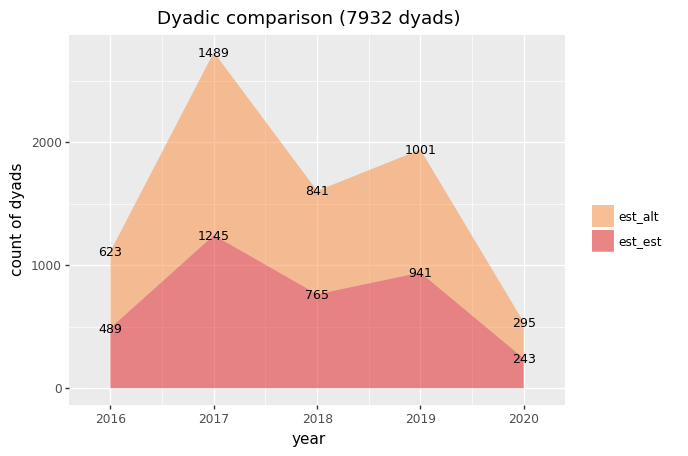

<ggplot: (8752394294827)>

In [25]:
c0

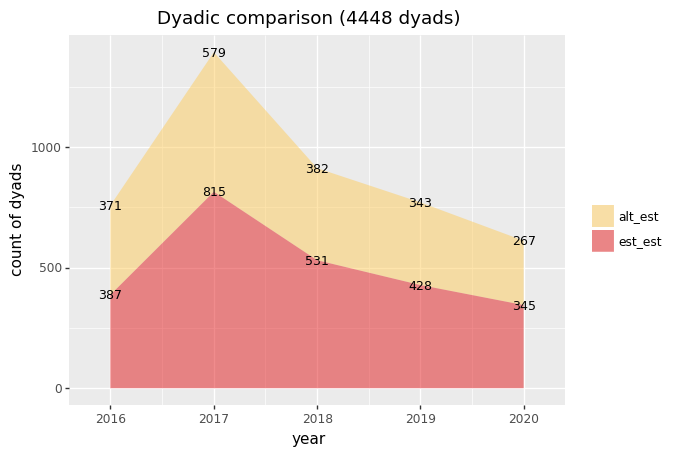

<ggplot: (8752383033763)>

In [26]:
c1

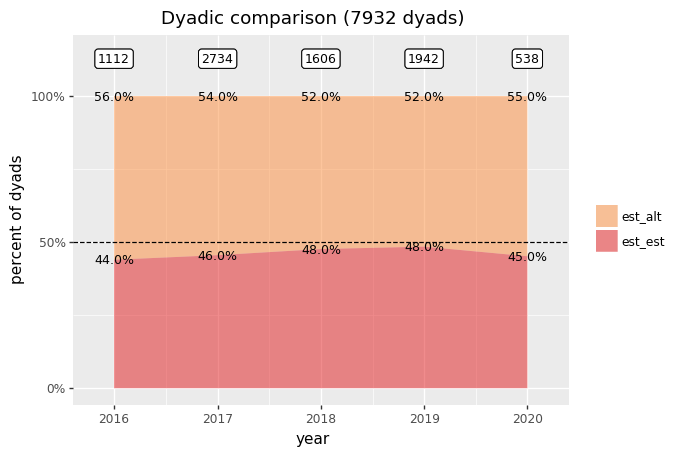

<ggplot: (8752356972855)>

In [27]:
p0

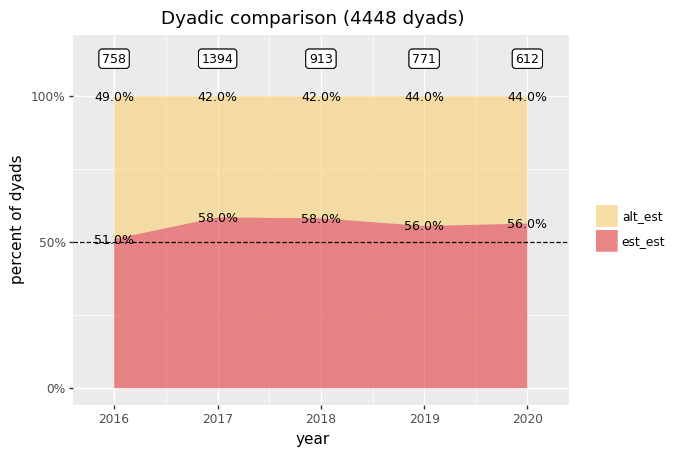

<ggplot: (8752356965057)>

In [28]:
p1

In [43]:
DOCTYPE_COMBOS = list(itertools.product(DOCTYPES, DOCTYPES))
DOCTYPE_COMBOS = [dc for dc in DOCTYPE_COMBOS if dc[0]!=dc[1]] # remove self-self
print(len(DOCTYPE_COMBOS))
DOCTYPE_COMBOS[0:5]

156


[('americanrenaissance', 'breitbart'),
 ('americanrenaissance', 'dailycaller'),
 ('americanrenaissance', 'dailystormer'),
 ('americanrenaissance', 'foxnews'),
 ('americanrenaissance', 'gatewaypundit')]

In [46]:
# plot_filtered_yearly_dyadic_comparison():
# when values0 and values1 each have exactly 1 doctype value,
# the function returns a 1-item list (1 plot) with both directions (displays at "doctype_to_doctype" level)
for combo in DOCTYPE_COMBOS:
    doctype0 = combo[0]
    doctype1 = combo[1]
    c = plot_filtered_yearly_dyadic_comparison(dyads_filtered,
                                       key0="doctype",
                                       key1="doctype",
                                       values0=[doctype0],
                                       values1=[doctype1],
                                       plot_type="count")[0]
    
    save_image(c, f"cnt_d0_outl_d1_outl_{doctype0}_{doctype1}")

    p = plot_filtered_yearly_dyadic_comparison(dyads_filtered,
                                           key0="doctype",
                                           key1="doctype",
                                           values0=[doctype0],
                                           values1=[doctype1],
                                           plot_type="percent")[0]
    
    save_image(p, f"pct_d0_outl_d1_outl_{doctype0}_{doctype1}")

/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 7 x 5 in image.
/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../figures/dyadic/svg/cnt_d0_outl_d1_outl_americanrenaissance_breitbart.svg
/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 7 x 5 in image.
/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../figures/dyadic/png/cnt_d0_outl_d1_outl_americanrenaissance_breitbart.png
/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 7 x 5 in image.
/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../figures/dyadic/svg/pct_d0_outl_d1_outl_americanrenaissance_breitbart.svg
/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 7 x 5 in image.
/home/jovyan/.loca

- compare selected established-right outlets based on their patterns as followers

In [28]:
# spot-check the yearly dyadic comparison
matched = get_matched_dyads(dyads=dyads_filtered,
                      d0_key="doctype_ideo",
                      d1_key="doctype",
                      d0_values=["alt", "est"],
                      d1_values=["foxnews"])

print(f"matched: {len(matched)} dyads")
print(f"matched per year: {sorted(Counter([m[0]['doc_publish_date'].year for m in matched]).items())}")

matched: 12248 dyads
matched per year: [(2016, 1008), (2017, 2012), (2018, 1938), (2019, 2895), (2020, 4395)]


------------------------------------------------------------------------------------------------------------------------
When ['foxnews'] is a follower, it follows alternative-right outlets (alt_est)% of the time and established-right outlets (est_est)% of the time.
------------------------------------------------------------------------------------------------------------------------
Leading doctype_ideo(s): ['alt', 'est']
Following doctype(s): ['foxnews']


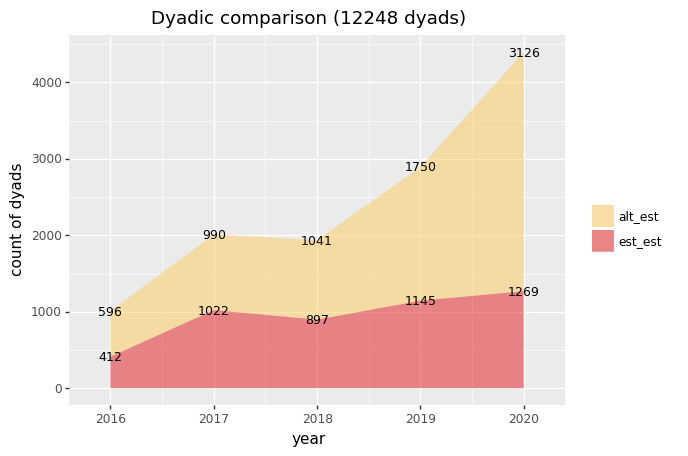

<ggplot: (8784529554439)>

------------------------------------------------------------------------------------------------------------------------
When ['washingtonexaminer'] is a follower, it follows alternative-right outlets (alt_est)% of the time and established-right outlets (est_est)% of the time.
------------------------------------------------------------------------------------------------------------------------
Leading doctype_ideo(s): ['alt', 'est']
Following doctype(s): ['washingtonexaminer']


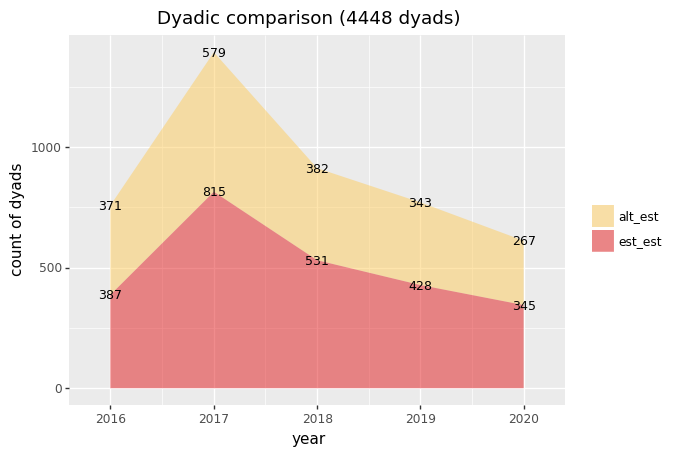

<ggplot: (8784529785911)>

In [36]:
for DOCTYPE in ["foxnews", "washingtonexaminer"]:
    KEY0 = "doctype"
    KEY1 = "doctype_ideo"
    VALUES0 = [DOCTYPE]
    DOCTYPE0_IDEO = IDEOS[list(df_ideo.loc[df_ideo["outlet_std"]==VALUES0[0]]["ideo_subcategory"])[0]]
    VALUES1 = ["alt", "est"]

    plots = plot_filtered_yearly_dyadic_comparison(dyads_filtered,
                                                   key0=KEY0,
                                                   key1=KEY1,
                                                   values0=VALUES0,
                                                   values1=VALUES1,
                                                   plot_type="count")

    # print("-"*120)
    # print(f"When {VALUES0} is a leader, it leads alternative-right outlets ({DOCTYPE0_IDEO}_alt)% of the time and established-right outlets ({DOCTYPE0_IDEO}_est)% of the time.")
    # print("-"*120)
    # print(f"Leading {KEY0}(s): {VALUES0}")
    # print(f"Following {KEY1}(s): {VALUES1}")
    # display(plots[0])

    print("-"*120)
    print(f"When {VALUES0} is a follower, it follows alternative-right outlets (alt_{DOCTYPE0_IDEO})% of the time and established-right outlets (est_{DOCTYPE0_IDEO})% of the time.")
    print("-"*120)
    print(f"Leading {KEY1}(s): {VALUES1}")
    print(f"Following {KEY0}(s): {VALUES0}")
    display(plots[1])

------------------------------------------------------------------------------------------------------------------------
When ['foxnews'] is a follower, it follows alternative-right outlets (alt_est)% of the time and established-right outlets (est_est)% of the time.
------------------------------------------------------------------------------------------------------------------------
Leading doctype_ideo(s): ['alt', 'est']
Following doctype(s): ['foxnews']


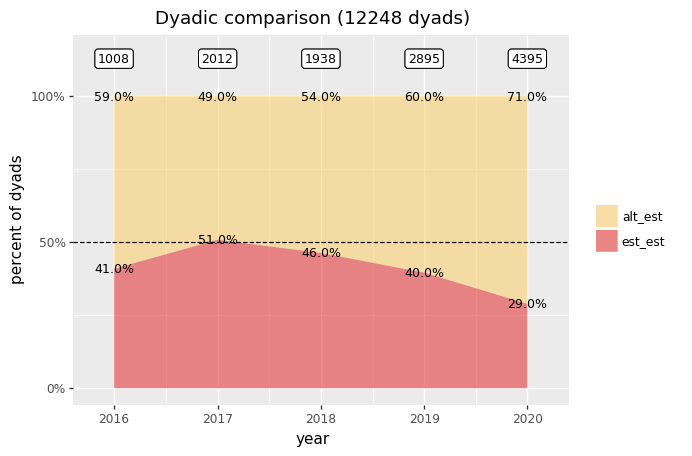

<ggplot: (8784561093012)>

------------------------------------------------------------------------------------------------------------------------
When ['washingtonexaminer'] is a follower, it follows alternative-right outlets (alt_est)% of the time and established-right outlets (est_est)% of the time.
------------------------------------------------------------------------------------------------------------------------
Leading doctype_ideo(s): ['alt', 'est']
Following doctype(s): ['washingtonexaminer']


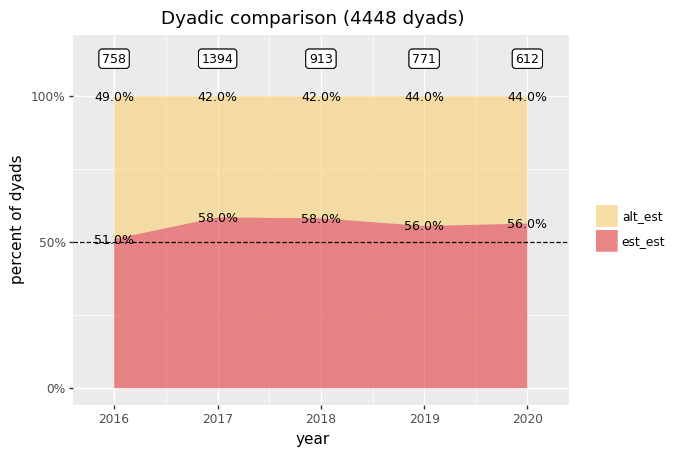

<ggplot: (8784560864793)>

In [29]:
for DOCTYPE in ["foxnews", "washingtonexaminer"]:
    KEY0 = "doctype"
    KEY1 = "doctype_ideo"
    VALUES0 = [DOCTYPE]
    DOCTYPE0_IDEO = IDEOS[list(df_ideo.loc[df_ideo["outlet_std"]==VALUES0[0]]["ideo_subcategory"])[0]]
    VALUES1 = ["alt", "est"]

    plots = plot_filtered_yearly_dyadic_comparison(dyads_filtered,
                                                   key0=KEY0,
                                                   key1=KEY1,
                                                   values0=VALUES0,
                                                   values1=VALUES1,
                                                   plot_type="percent")

    # print("-"*120)
    # print(f"When {VALUES0} is a leader, it leads alternative-right outlets ({DOCTYPE0_IDEO}_alt)% of the time and established-right outlets ({DOCTYPE0_IDEO}_est)% of the time.")
    # print("-"*120)
    # print(f"Leading {KEY0}(s): {VALUES0}")
    # print(f"Following {KEY1}(s): {VALUES1}")
    # display(plots[0])

    print("-"*120)
    print(f"When {VALUES0} is a follower, it follows alternative-right outlets (alt_{DOCTYPE0_IDEO})% of the time and established-right outlets (est_{DOCTYPE0_IDEO})% of the time.")
    print("-"*120)
    print(f"Leading {KEY1}(s): {VALUES1}")
    print(f"Following {KEY0}(s): {VALUES0}")
    display(plots[1])

- see `doctype_to_doctype` for Fox News

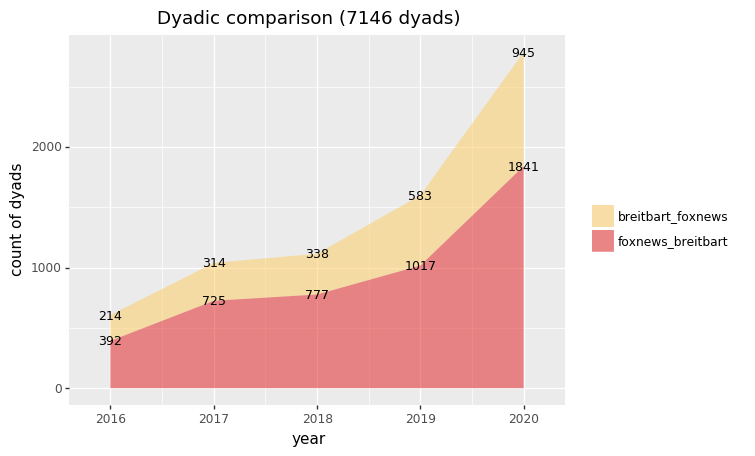

[<ggplot: (8784532026399)>]

In [38]:
# plot_filtered_yearly_dyadic_comparison():
# when values0 and values1 each have exactly 1 doctype value,
# the function returns 1 plot with both directions (displays at "doctype_to_doctype" level)

KEY0 = "doctype"
KEY1 = "doctype"
VALUES0 = ["breitbart"] # ALT_RIGHT_DOCTYPES
VALUES1 = ["foxnews"]

for DOCTYPE in VALUES0:
    display(plot_filtered_yearly_dyadic_comparison(dyads_filtered,
                                                   key0=KEY0,
                                                   key1=KEY1,
                                                   values0=[DOCTYPE],
                                                   values1=VALUES1,
                                                   plot_type="count"))

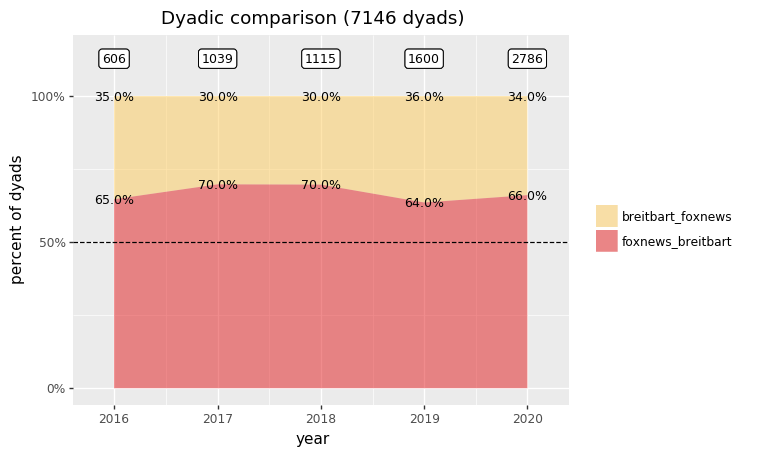

[<ggplot: (8784561272423)>]

In [30]:
# plot_filtered_yearly_dyadic_comparison():
# when values0 and values1 each have exactly 1 doctype value,
# the function returns 1 plot with both directions (displays at "doctype_to_doctype" level)

KEY0 = "doctype"
KEY1 = "doctype"
VALUES0 = ["breitbart"] # ALT_RIGHT_DOCTYPES
VALUES1 = ["foxnews"]

for DOCTYPE in VALUES0:
    display(plot_filtered_yearly_dyadic_comparison(dyads_filtered,
                                                   key0=KEY0,
                                                   key1=KEY1,
                                                   values0=[DOCTYPE],
                                                   values1=VALUES1,
                                                   plot_type="percent"))

- compare selected alternative-right outlets based on their patterns as leaders

------------------------------------------------------------------------------------------------------------------------
When ['breitbart'] is a leader, it leads alternative-right outlets (alt_alt)% of the time and established-right outlets (alt_est)% of the time.
------------------------------------------------------------------------------------------------------------------------
Leading doctype(s): ['breitbart']
Following doctype_ideo(s): ['alt', 'est']


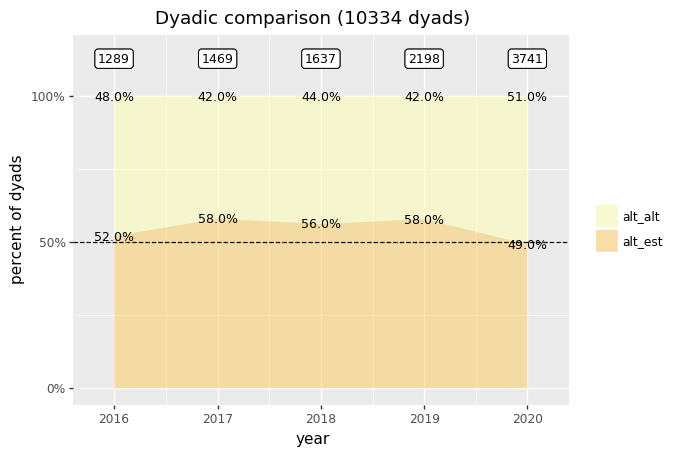

<ggplot: (8784561334914)>

------------------------------------------------------------------------------------------------------------------------
When ['gatewaypundit'] is a leader, it leads alternative-right outlets (alt_alt)% of the time and established-right outlets (alt_est)% of the time.
------------------------------------------------------------------------------------------------------------------------
Leading doctype(s): ['gatewaypundit']
Following doctype_ideo(s): ['alt', 'est']


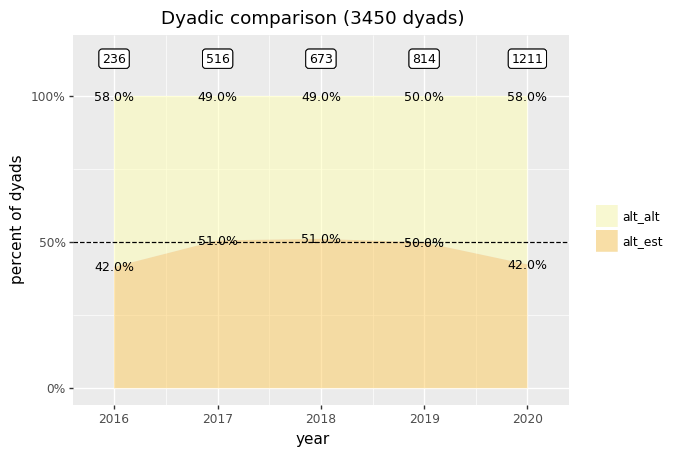

<ggplot: (8784560953034)>

------------------------------------------------------------------------------------------------------------------------
When ['newsmax'] is a leader, it leads alternative-right outlets (alt_alt)% of the time and established-right outlets (alt_est)% of the time.
------------------------------------------------------------------------------------------------------------------------
Leading doctype(s): ['newsmax']
Following doctype_ideo(s): ['alt', 'est']


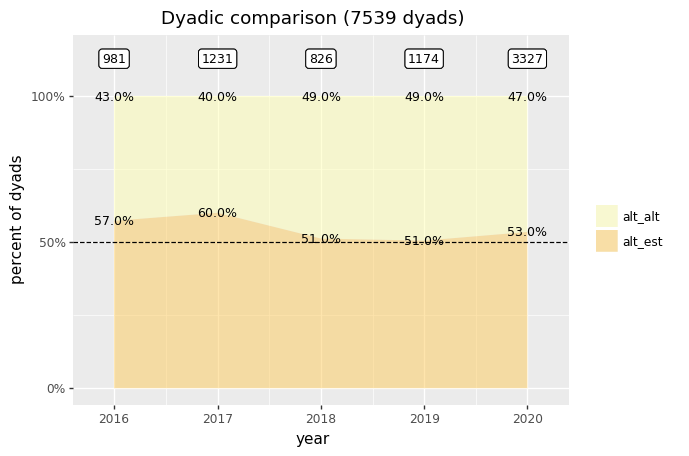

<ggplot: (8784560701983)>

------------------------------------------------------------------------------------------------------------------------
When ['oneamericanews'] is a leader, it leads alternative-right outlets (alt_alt)% of the time and established-right outlets (alt_est)% of the time.
------------------------------------------------------------------------------------------------------------------------
Leading doctype(s): ['oneamericanews']
Following doctype_ideo(s): ['alt', 'est']


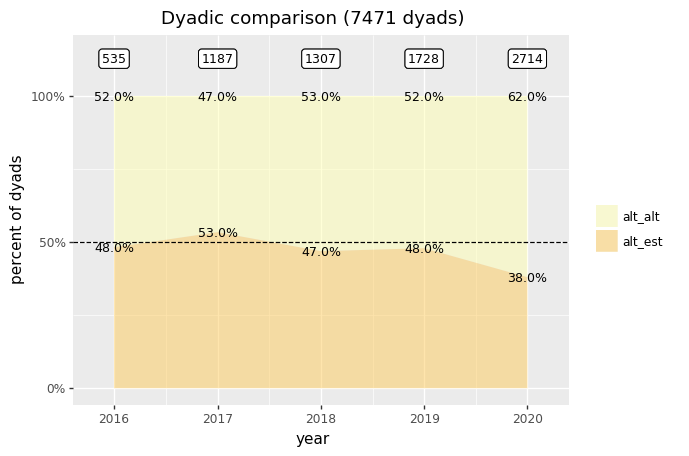

<ggplot: (8784560989910)>

In [31]:
for DOCTYPE in ["breitbart", "gatewaypundit", "newsmax", "oneamericanews"]:
    KEY0 = "doctype"
    KEY1 = "doctype_ideo"
    VALUES0 = [DOCTYPE]
    DOCTYPE0_IDEO = IDEOS[list(df_ideo.loc[df_ideo["outlet_std"]==VALUES0[0]]["ideo_subcategory"])[0]]
    VALUES1 = ["alt", "est"]

    plots = plot_filtered_yearly_dyadic_comparison(dyads_filtered,
                                                   key0=KEY0,
                                                   key1=KEY1,
                                                   values0=VALUES0,
                                                   values1=VALUES1,
                                                   plot_type="percent")

    print("-"*120)
    print(f"When {VALUES0} is a leader, it leads alternative-right outlets ({DOCTYPE0_IDEO}_alt)% of the time and established-right outlets ({DOCTYPE0_IDEO}_est)% of the time.")
    print("-"*120)
    print(f"Leading {KEY0}(s): {VALUES0}")
    print(f"Following {KEY1}(s): {VALUES1}")
    display(plots[0])

    # print("-"*120)
    # print(f"When {VALUES0} is a follower, it follows alternative-right outlets (alt_{DOCTYPE0_IDEO})% of the time and established-right outlets (est_{DOCTYPE0_IDEO})% of the time.")
    # print("-"*120)
    # print(f"Leading {KEY1}(s): {VALUES1}")
    # print(f"Following {KEY0}(s): {VALUES0}")
    # display(plots[1])

<hr>

## Dev version

### 1. Load/filter dataframe of multi-article clusters

In [32]:
df_clusters_dev = load_multi_doc_clusters_only(df_dir, "softcos09_dev")
df_clusters_dev = df_clusters_dev.loc[df_clusters_dev["cluster_id"].isin(
    ["softcos09_0",
     "softcos09_1",
     "softcos09_1018",
     "softcos09_8",
     "softcos09_1019"])].reset_index(drop=True)

df_clusters_dev["doctype"] = df_clusters_dev["doc_id"].map(lambda d: extract_doctype(d))
df_clusters_dev["doctype_ideo"] = df_clusters_dev["doctype"].map(lambda d: get_ideo_subcategory(d))
df_clusters_dev["doc_topic"] = df_clusters_dev["doc_id"].map(lambda d: get_doc_topic(d))

# more efficient to query all doc_ids together than to send an HTTP request to ES for each doc_id.
# store the retrieved data in a helper dataframe (df_topics, df_tw) which is then used to populate df_clusters.

# TODO
# df_topic_dev = get_field_value_for_ids(list(df_clusters_dev["doc_id"]), "topic")
# df_clusters_dev["doc_topic"] = df_clusters_dev["doc_id"].map(lambda d: df_topic_dev.at[d, "topic"])

df_tw_dev = get_field_value_for_ids(list(df_clusters_dev["doc_id"]), "tweets2_url_ids")
df_clusters_dev["doc_tw"] = df_clusters_dev["doc_id"].map(lambda d: df_tw_dev.at[d, "tweets2_url_ids"])

df_clusters_dev_filtered = filter_clusters(
                            df_clusters_dev,
                            rmv_docs_with_odd_publish_date_ind=True,
                            filters={"years": [],
                                     "topics": []}
                        )

100%|██████████| 19/19 [00:00<00:00, 639.33it/s]


`rmv_docs_with_odd_publish_date_ind=True`: only keep a document if it is not published at exactly 05:00 UTC (midnight EST)
- `softcos09_0`: first 2 docs are odd -> first 2 docs are removed
- `softcos09_1`: no docs are odd -> no docs removed
- `softcos09_1018`: first doc is odd -> first doc is removed
- `softcos09_8`: all docs are odd -> all docs removed
- `softcos09_1019`: non-first doc is odd -> no docs removed

`filters, years`: keep the cluster if its first document was published in one of the specified years

`filters, topics`: keep the cluster if its first document was assigned one of the specified topics

In [33]:
df_clusters_dev

,cluster_id,cluster_size,doc_id,doc_publish_date,doc_title,doctype,doctype_ideo,doc_topic,doc_tw
0,softcos09_0,6,FoxNews_1335667092,2017-01-20 05:00:00+00:00,Full text of President Donald Trump's inaugura...,foxnews,est,topic1,[]
1,softcos09_0,6,Newsmax_808871458,2017-01-20 05:00:00+00:00,Transcript of Donald Trump's Inaugural Address...,newsmax,alt,topic3,[]
2,softcos09_0,6,Breitbart_569964901,2017-01-20 17:52:32+00:00,Complete Text of President Donald Trump’s Inau...,breitbart,alt,topic3,[]
3,softcos09_0,6,FoxNews_747297287,2017-01-20 19:06:12+00:00,"Donald Trump Inaugural Address: Video Clips, Q...",foxnews,est,topic1,[]
4,softcos09_0,6,Breitbart_569964888,2017-01-20 19:48:59+00:00,‘America First’: President Donald Trump Brings...,breitbart,alt,topic3,[]
5,softcos09_0,6,DailyStormer_570028239,2017-01-20 23:24:18+00:00,Meme Magic: President Trump Channels Bane in I...,dailystormer,alt,topic2,[]
6,softcos09_1,5,OneAmericaNews_581668214,2017-02-16 02:00:27+00:00,Robert Durst of &#8216;The Jinx&#8217; sees ol...,oneamericanews,alt,topic2,[]
7,softcos09_1,5,FoxNews_582065065,2017-02-16 18:30:46+00:00,The Latest: Ex-friend's testifies Durst said h...,foxnews,est,topic1,[]
8,softcos09_1,5,FoxNews_582156768,2017-02-16 23:27:34+00:00,"Durst told friend he killed mutual friend, key...",foxnews,est,topic2,[]
9,softcos09_1,5,OneAmericaNews_582523442,2017-02-17 18:15:21+00:00,Durst of &#8216;The Jinx&#8217; HBO series fac...,oneamericanews,alt,topic3,[]


In [34]:
df_clusters_dev_filtered

,cluster_id,cluster_size,doc_id,doc_publish_date,doc_title,doctype,doctype_ideo,doc_topic,doc_tw
0,softcos09_0,6,Breitbart_569964901,2017-01-20 17:52:32+00:00,Complete Text of President Donald Trump’s Inau...,breitbart,alt,topic3,[]
1,softcos09_0,6,FoxNews_747297287,2017-01-20 19:06:12+00:00,"Donald Trump Inaugural Address: Video Clips, Q...",foxnews,est,topic1,[]
2,softcos09_0,6,Breitbart_569964888,2017-01-20 19:48:59+00:00,‘America First’: President Donald Trump Brings...,breitbart,alt,topic3,[]
3,softcos09_0,6,DailyStormer_570028239,2017-01-20 23:24:18+00:00,Meme Magic: President Trump Channels Bane in I...,dailystormer,alt,topic2,[]
4,softcos09_1,5,OneAmericaNews_581668214,2017-02-16 02:00:27+00:00,Robert Durst of &#8216;The Jinx&#8217; sees ol...,oneamericanews,alt,topic2,[]
5,softcos09_1,5,FoxNews_582065065,2017-02-16 18:30:46+00:00,The Latest: Ex-friend's testifies Durst said h...,foxnews,est,topic1,[]
6,softcos09_1,5,FoxNews_582156768,2017-02-16 23:27:34+00:00,"Durst told friend he killed mutual friend, key...",foxnews,est,topic2,[]
7,softcos09_1,5,OneAmericaNews_582523442,2017-02-17 18:15:21+00:00,Durst of &#8216;The Jinx&#8217; HBO series fac...,oneamericanews,alt,topic3,[]
8,softcos09_1,5,Newsmax_713013462,2017-02-17 19:58:17+00:00,"Robert Durst Admitted Killing Friend, Secret W...",newsmax,alt,topic1,[]
9,softcos09_1018,2,WashingtonExaminer_776070968,2018-01-20 22:21:00+00:00,Military members and families deployed oversea...,washingtonexaminer,est,topic2,[]
